In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras import utils,optimizers
import numpy as np
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plot
import os, math
from random import randint

In [ ]:
def hist(image):
    r, g, b = cv2.split(image)
    r1 = cv2.equalizeHist(r)
    g1 = cv2.equalizeHist(g)
    b1 = cv2.equalizeHist(b)
    image_equal_clo = cv2.merge([r1, g1, b1])
    return image_equal_clo



def laplacian(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image_lap = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return image_lap



def log(image):
    image_log = np.uint8(np.log(np.array(image) + 1))
    cv2.normalize(image_log, image_log, 0, 255, cv2.NORM_MINMAX)
    cv2.convertScaleAbs(image_log, image_log)
    return image_log


def gamma(image):
    fgamma = 2
    image_gamma = np.uint8(np.power((np.array(image) / 255.0), fgamma) * 255.0)
    cv2.normalize(image_gamma, image_gamma, 0, 255, cv2.NORM_MINMAX)
    cv2.convertScaleAbs(image_gamma, image_gamma)
    return image_gamma


def clahe(image):
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    image_clahe = cv2.merge([b, g, r])
    return image_clahe


def replaceZeroes(data):
    min_nonzero = min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data


# retinex SSR
def SSR(src_img, size):
    L_blur = cv2.GaussianBlur(src_img, (size, size), 0)
    img = replaceZeroes(src_img)
    L_blur = replaceZeroes(L_blur)

    dst_Img = cv2.log(img/255.0)
    dst_Lblur = cv2.log(L_blur/255.0)
    dst_IxL = cv2.multiply(dst_Img, dst_Lblur)
    log_R = cv2.subtract(dst_Img, dst_IxL)

    dst_R = cv2.normalize(log_R,None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8


def SSR_image(image):
    size = 3
    b_gray, g_gray, r_gray = cv2.split(image)
    b_gray = SSR(b_gray, size)
    g_gray = SSR(g_gray, size)
    r_gray = SSR(r_gray, size)
    result = cv2.merge([b_gray, g_gray, r_gray])
    return result


# retinex MMR
def MSR(img, scales):
    weight = 1 / 3.0
    scales_size = len(scales)
    h, w = img.shape[:2]
    log_R = np.zeros((h, w), dtype=np.float32)

    for i in range(scales_size):
        img = replaceZeroes(img)
        L_blur = cv2.GaussianBlur(img, (scales[i], scales[i]), 0)
        L_blur = replaceZeroes(L_blur)
        dst_Img = cv2.log(img/255.0)
        dst_Lblur = cv2.log(L_blur/255.0)
        dst_Ixl = cv2.multiply(dst_Img, dst_Lblur)
        log_R += weight * cv2.subtract(dst_Img, dst_Ixl)

    dst_R = cv2.normalize(log_R,None, 0, 255, cv2.NORM_MINMAX)
    log_uint8 = cv2.convertScaleAbs(dst_R)
    return log_uint8


def MSR_image(image):
    scales = [15, 101, 301]  # [3,5,9]
    b_gray, g_gray, r_gray = cv2.split(image)
    b_gray = MSR(b_gray, scales)
    g_gray = MSR(g_gray, scales)
    r_gray = MSR(r_gray, scales)
    result = cv2.merge([b_gray, g_gray, r_gray])
    return result

In [ ]:
def get_class_list():
  crop_list = ['Kirmizi_Pistachio','Siirt_Pistachio']
  return crop_list

# 取得訓練集影像及label值
def get_images(directory):
    Images = []
    Labels = []#對應的類別名稱
    label = 0
    classes = get_class_list()
    for folder in os.listdir(directory): # 影像分別儲存在以類別命名的資料夾.
        label = classes.index(folder) # 依資料夾名稱轉換為label值
        print('資料夾 {} 讀取中 ....'.format(folder))
        for img_file in os.listdir(os.path.join(directory, folder)):
            image = cv2.imread(os.path.join(directory, folder, img_file)) # OpenCV 讀取影像資料
            image = cv2.resize(image,(224,224))    #解析度進行縮放
            image = hist(image)
            Images.append(image)
            Labels.append(label)

    print('資料已讀取完成.')
    return shuffle(Images,Labels) # 隨機排序

# 依label值轉換為類別名稱
def get_class(label_code):
    classes = get_class_list();
    return classes[label_code]

In [ ]:
train_dir = '/content/drive/MyDrive/研究所課程/統計分析程式/HW11_/Pistachio/Train'

In [ ]:
train_images, train_labels = get_images(train_dir)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

資料夾 Kirmizi_Pistachio 讀取中 ....
資料夾 Siirt_Pistachio 讀取中 ....
資料已讀取完成.


In [ ]:
print("Shape of Images:",train_images.shape)
print("Shape of Labels:",train_labels.shape)

Shape of Images: (1758, 224, 224, 3)
Shape of Labels: (1758,)


In [ ]:
def plot_images(Images, Labels, Prediction=[], num=18):
    if num > 30: num = 30
    row = math.ceil(num/5)
    fig, ax = plot.subplots(row, 5, figsize=(24, row*3))
    pic = 1
    for i in range(row):
      for j in range(5):
        if pic <= num:
          idx = randint(0,len(Images)-1)
          ax[i,j].imshow(Images[idx])
          title = get_class(Labels[idx])
          if len(Prediction) > 0:
            title = "gt={},p={}".format(title, get_class(Prediction[idx]))
          ax[i,j].set_title(title)

        ax[i,j].axis('off')
        pic += 1
    plot.show()

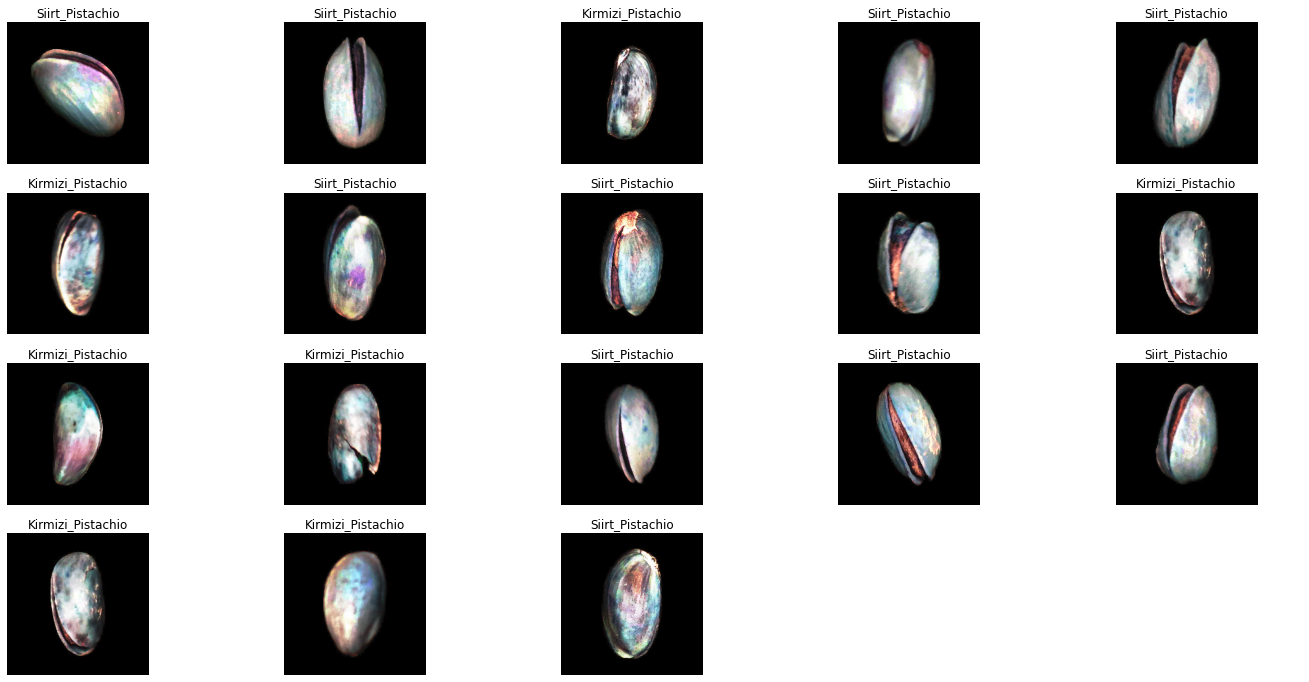

In [ ]:
plot_images(train_images, train_labels)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) #一維向量
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(2, activation='softmax')) #進行正規劃


opt = optimizers.Adam(learning_rate=0.0001) #權重更新
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
train_history = model.fit(x=train_images, y=train_labels, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
44/44 [==============================] - 13s 281ms/step - loss: 1.2105 - accuracy: 0.6622 - val_loss: 0.5453 - val_accuracy: 0.7528
Epoch 2/10
44/44 [==============================] - 12s 277ms/step - loss: 0.3555 - accuracy: 0.8385 - val_loss: 0.2778 - val_accuracy: 0.8892
Epoch 3/10
44/44 [==============================] - 12s 280ms/step - loss: 0.2481 - accuracy: 0.8983 - val_loss: 0.2743 - val_accuracy: 0.8920
Epoch 4/10
44/44 [==============================] - 12s 274ms/step - loss: 0.2123 - accuracy: 0.9118 - val_loss: 0.2754 - val_accuracy: 0.8864
Epoch 5/10
44/44 [==============================] - 12s 270ms/step - loss: 0.1655 - accuracy: 0.9339 - val_loss: 0.2127 - val_accuracy: 0.9205
Epoch 6/10
44/44 [==============================] - 11s 261ms/step - loss: 0.1295 - accuracy: 0.9509 - val_loss: 0.2053 - val_accuracy: 0.9119
Epoch 7/10
44/44 [==============================] - 12s 273ms/step - loss: 0.0973 - accuracy: 0.9630 - val_loss: 0.1606 - val_accuracy: 0.9403

In [ ]:
scores = model.evaluate(train_images, train_labels)
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

55/55 [==============================] - 5s 79ms/step - loss: 0.0673 - accuracy: 0.9767
	[Info] Accuracy of testing data = 97.7%


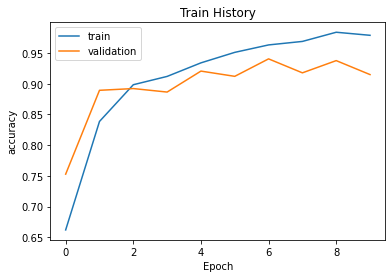

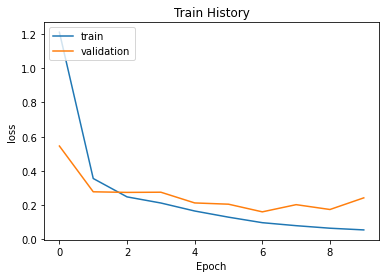

In [ ]:
def show_train_history(train_history, train, validation):
    plot.plot(train_history.history[train])
    plot.plot(train_history.history[validation])
    plot.title('Train History')
    plot.ylabel(train)
    plot.xlabel('Epoch')
    plot.legend(['train', 'validation'], loc='upper left')
    plot.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
test_dir = '/content/drive/MyDrive/研究所課程/統計分析程式/HW11_/Pistachio/Test/'
test_images,test_labels = get_images(test_dir)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of Images:",test_images.shape)
print("Shape of Labels:",test_labels.shape)

資料夾 Siirt_Pistachio 讀取中 ....
資料夾 Kirmizi_Pistachio 讀取中 ....
資料已讀取完成.
Shape of Images: (360, 224, 224, 3)
Shape of Labels: (360,)


In [ ]:
model.evaluate(test_images, test_labels)

12/12 [==============================] - 1s 80ms/step - loss: 0.1459 - accuracy: 0.9500


[0.1459493488073349, 0.949999988079071]

12/12 [==============================] - 1s 83ms/step
gt:ground truth, p: prediction



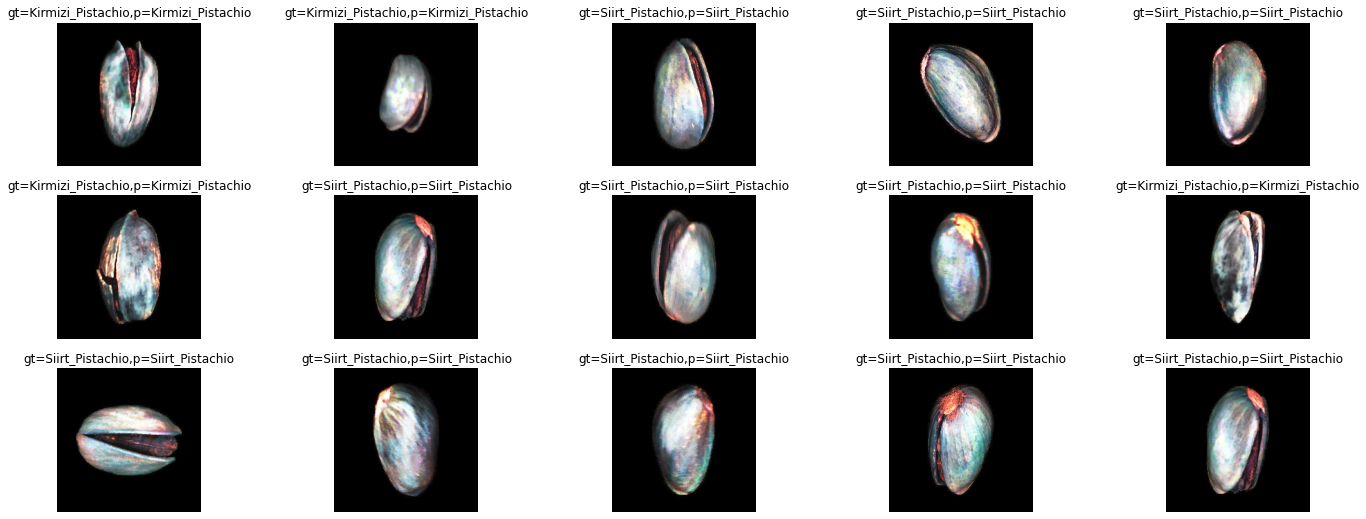

In [ ]:
prediction_prob = model.predict(test_images)
prediction = np.argmax(prediction_prob,axis=1)

print("gt:ground truth, p: prediction\n")
plot_images(test_images, test_labels, prediction, 15)

In [ ]:
pred_dir = '/content/drive/MyDrive/研究所課程/統計分析程式/HW11_/Pistachio/P/'
pred_images=[]
for img_file in os.listdir(pred_dir):
  image = cv2.imread(os.path.join(pred_dir,img_file))
  image = cv2.resize(image,(224,224))
  image = hist(image)
  pred_images.append(image)

print(len(pred_images))

40


1/1 [==============================] - 0s 18ms/step


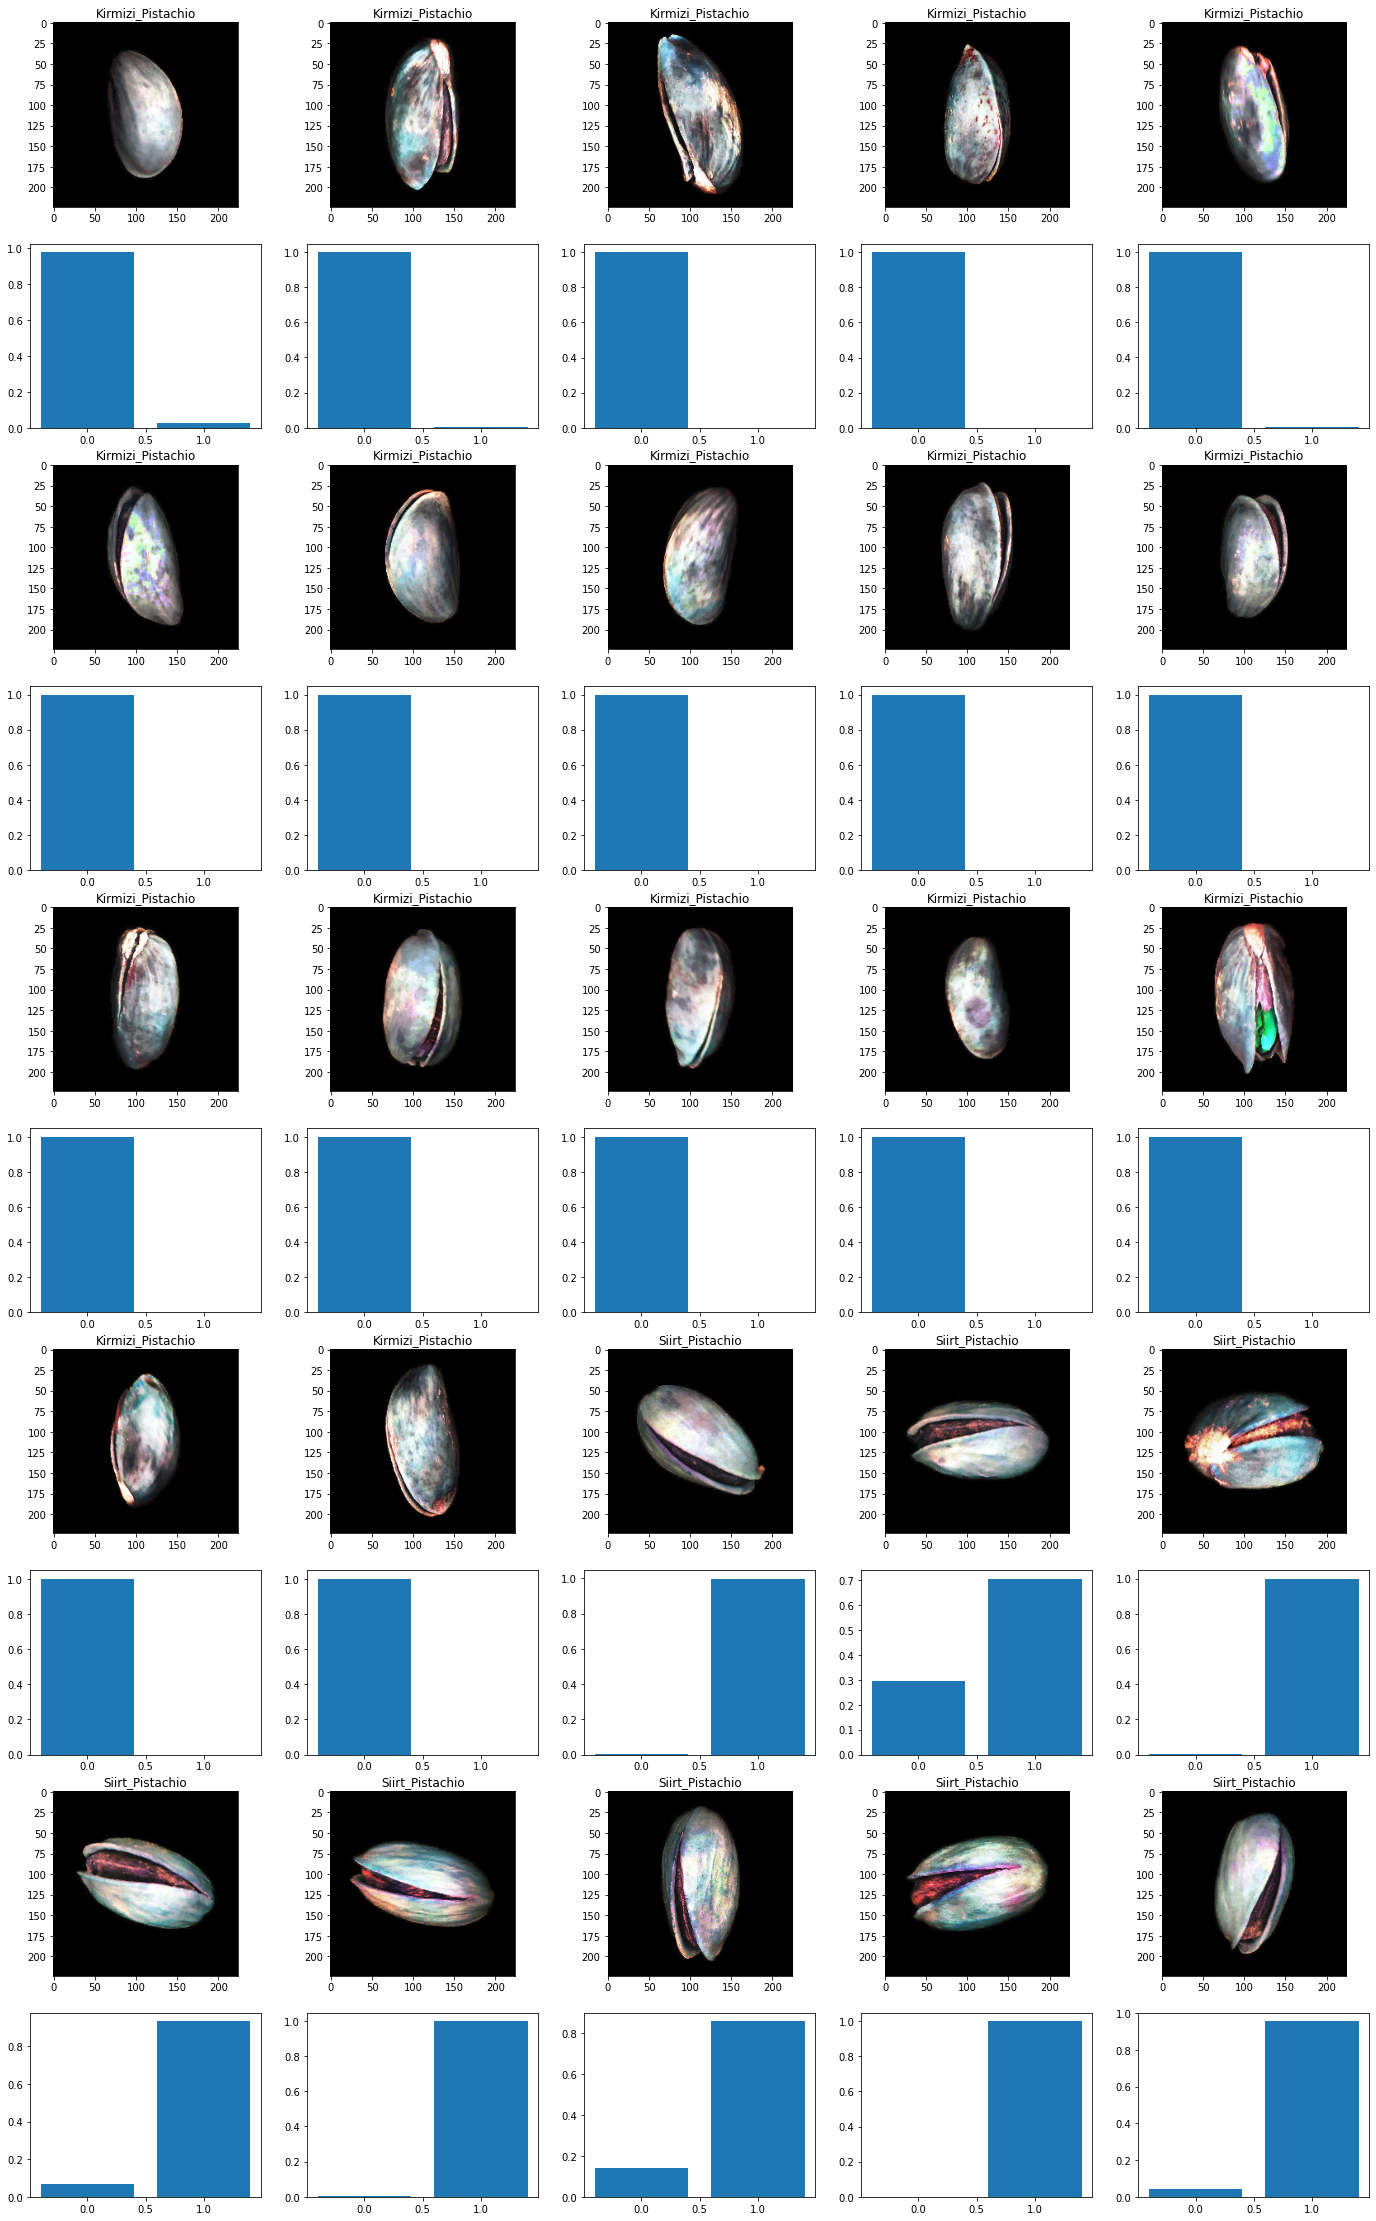

In [ ]:
row = 10
fig, ax = plot.subplots(row, 5, figsize=(24, 40))
i = 0   # 列數
pic1 = 0  # image圖 index
pic2 = 0  # bar 圖 index
while i < row:
  # 第一列顯示影像
  for j in range(5):
    pred_image = np.array([pred_images[pic1]])
    pred_prob = model.predict(pred_image)[0]
    pred_label = np.argmax(pred_prob)      # 回傳最大數值的位置(index).
    pred_class = get_class(pred_label)
    ax[i,j].imshow(pred_images[pic1])
    ax[i,j].set_title(pred_class)
    pic1+=1

  # 第二列顯示預測的機率
  i+=1
  for j in range(5):
    pred_image = np.array([pred_images[pic2]])
    pred_prob = model.predict(pred_image)[0]
    prob_value = pred_prob.reshape(2)
    ax[i,j].bar(range(2),prob_value)
    pic2+=1
  i+=1